# Практична робота №1: Множинна лінійна регресія методом градієнтного спуску
**Предмет:** Машинне навчання

---

## Зміст:
1. Підготовка даних (Data Preprocessing)
2. Реалізація градієнтного спуску з нуля
3. Оцінка якості моделі
4. Перевірка припущень класичної лінійної регресії
5. Загальний висновок

## 1. ПІДГОТОВКА ДАНИХ (Data Preprocessing)

### 1.1 Імпорт бібліотек

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings

warnings.filterwarnings('ignore')

# Налаштування візуалізації
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("=" * 80)
print("МНОЖИННА ЛІНІЙНА РЕГРЕСІЯ: АНАЛІЗ УСПІШНОСТІ СТУДЕНТІВ")
print("=" * 80)

МНОЖИННА ЛІНІЙНА РЕГРЕСІЯ: АНАЛІЗ УСПІШНОСТІ СТУДЕНТІВ


### 1.2 Завантаження даних

In [32]:
# Завантаження датасету
df = pd.read_csv('Student_Performance.csv')

print("\n1. ЗАВАНТАЖЕННЯ ТА РОЗВІДКОВИЙ АНАЛІЗ ДАНИХ")
print("-" * 80)


1. ЗАВАНТАЖЕННЯ ТА РОЗВІДКОВИЙ АНАЛІЗ ДАНИХ
--------------------------------------------------------------------------------


### 1.3 Розвідковий аналіз (EDA)

In [33]:
print("\n1.1 Інформація про датасет:")
print(df.info())


1.1 Інформація про датасет:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB
None


In [34]:
print("\n1.2 Статистичний опис:")
print(df.describe())


1.2 Статистичний опис:
       Hours Studied  Previous Scores   Sleep Hours  \
count   10000.000000     10000.000000  10000.000000   
mean        4.992900        69.445700      6.530600   
std         2.589309        17.343152      1.695863   
min         1.000000        40.000000      4.000000   
25%         3.000000        54.000000      5.000000   
50%         5.000000        69.000000      7.000000   
75%         7.000000        85.000000      8.000000   
max         9.000000        99.000000      9.000000   

       Sample Question Papers Practiced  Performance Index  
count                      10000.000000       10000.000000  
mean                           4.583300          55.224800  
std                            2.867348          19.212558  
min                            0.000000          10.000000  
25%                            2.000000          40.000000  
50%                            5.000000          55.000000  
75%                            7.000000          71.0

In [35]:
print("\n1.3 Перші рядки датасету:")
print(df.head())


1.3 Перші рядки датасету:
   Hours Studied  Previous Scores Extracurricular Activities  Sleep Hours  \
0              7               99                        Yes            9   
1              4               82                         No            4   
2              8               51                        Yes            7   
3              5               52                        Yes            5   
4              7               75                         No            8   

   Sample Question Papers Practiced  Performance Index  
0                                 1               91.0  
1                                 2               65.0  
2                                 2               45.0  
3                                 2               36.0  
4                                 5               66.0  


In [36]:
print("\n1.4 Перевірка на пропущені значення:")
print(df.isnull().sum())


1.4 Перевірка на пропущені значення:
Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64


### 1.5 Візуалізація кореляцій


1.5 Кореляційна матриця створена...


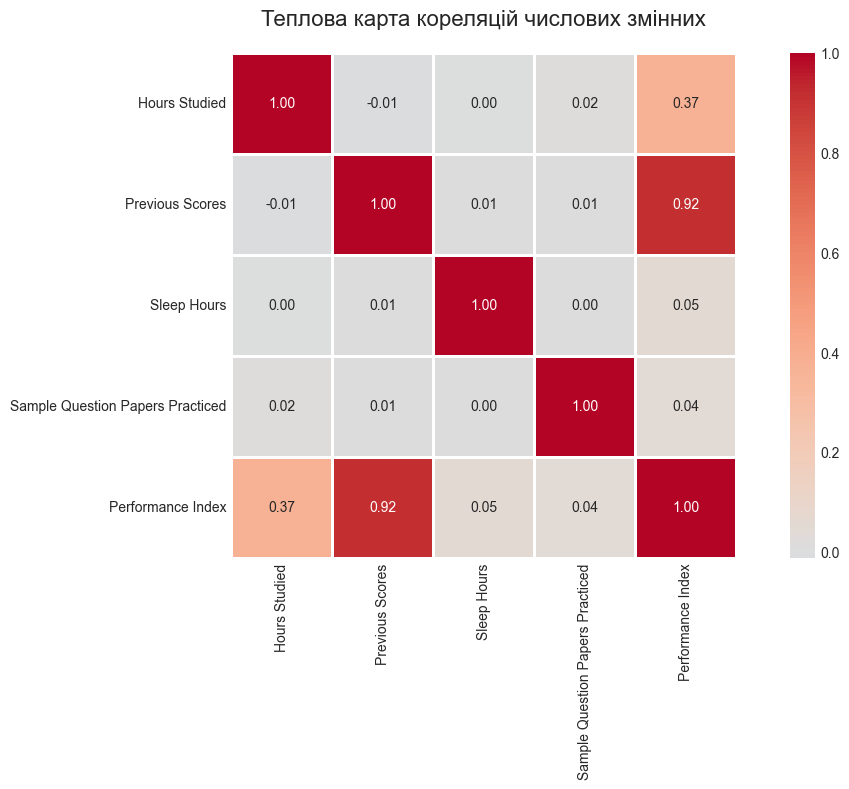

In [37]:
print("\n1.5 Кореляційна матриця створена...")
plt.figure(figsize=(12, 8))
# Виділяємо тільки числові колонки
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1)
plt.title('Теплова карта кореляцій числових змінних', fontsize=16, pad=20)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

### 1.4 Обробка категоріальних змінних

In [38]:
print("\n1.6 Обробка категоріальних змінних...")
df_processed = df.copy()

# Перевіряємо наявність бінарних категоріальних змінних
categorical_cols = df.select_dtypes(include=['object']).columns
print(f"Категоріальні колонки: {list(categorical_cols)}")

# Кодування бінарних змінних (якщо є)
for col in categorical_cols:
    unique_values = df[col].unique()
    if len(unique_values) == 2:
        # Бінарне кодування
        df_processed[col] = df[col].map({unique_values[0]: 0, unique_values[1]: 1})
        print(f"  - {col}: {unique_values[0]} -> 0, {unique_values[1]} -> 1")


1.6 Обробка категоріальних змінних...
Категоріальні колонки: ['Extracurricular Activities']
  - Extracurricular Activities: Yes -> 0, No -> 1


### 1.5 Вибір ознак та цільової змінної

In [39]:
print("\n1.7 Вибір ознак та цільової змінної...")

# Цільова змінна
target_col = 'Performance Index'
y = df_processed[target_col].values

# Ознаки (всі колонки крім цільової)
feature_cols = [col for col in df_processed.columns if col != target_col]
X = df_processed[feature_cols].values

print(f"  - Цільова змінна: {target_col}")
print(f"  - Кількість ознак: {X.shape[1]}")
print(f"  - Назви ознак: {feature_cols}")
print(f"  - Кількість зразків: {X.shape[0]}")


1.7 Вибір ознак та цільової змінної...
  - Цільова змінна: Performance Index
  - Кількість ознак: 5
  - Назви ознак: ['Hours Studied', 'Previous Scores', 'Extracurricular Activities', 'Sleep Hours', 'Sample Question Papers Practiced']
  - Кількість зразків: 10000


### 1.6 Поділ на навчальну та тестову вибірки

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\n1.8 Поділ даних:")
print(f"  - Навчальна вибірка: {X_train.shape[0]} зразків")
print(f"  - Тестова вибірка: {X_test.shape[0]} зразків")


1.8 Поділ даних:
  - Навчальна вибірка: 8000 зразків
  - Тестова вибірка: 2000 зразків


### 1.7 Нормалізація/Стандартизація

In [41]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Додаємо стовпчик одиниць для intercept β_0
X_train_final = np.c_[np.ones(X_train_scaled.shape[0]), X_train_scaled]
X_test_final = np.c_[np.ones(X_test_scaled.shape[0]), X_test_scaled]

print(f"\n1.9 Після стандартизації та додавання intercept:")
print(f"  - Розмірність X_train_final: {X_train_final.shape}")
print(f"  - Розмірність X_test_final: {X_test_final.shape}")


1.9 Після стандартизації та додавання intercept:
  - Розмірність X_train_final: (8000, 6)
  - Розмірність X_test_final: (2000, 6)


## 2. РЕАЛІЗАЦІЯ ГРАДІЄНТНОГО СПУСКУ З НУЛЯ

### 2.1 Функції для градієнтного спуску

In [42]:
def compute_cost(X, y, b):
    """
    Обчислює середню квадратичну помилку (MSE).
    
    Параметри:
    X: матриця ознак (n x m+1)
    y: вектор цільових значень (n,)
    b: вектор параметрів (m+1,)
    
    Повертає:
    mse: середня квадратична помилка
    """
    predictions = X.dot(b)
    errors = predictions - y
    mse = (1 / len(y)) * np.sum(errors ** 2)
    return mse


def gradient_descent(X, y, b, learning_rate, epochs, verbose=True):
    """
    Реалізація методу градієнтного спуску для лінійної регресії.
    
    Параметри:
    X: матриця ознак (n x m+1)
    y: вектор цільових значень (n,)
    b: початковий вектор параметрів (m+1,)
    learning_rate: швидкість навчання
    epochs: кількість ітерацій
    verbose: виводити прогрес
    
    Повертає:
    b: оптимізований вектор параметрів
    cost_history: історія значень функції втрат
    """
    cost_history = []  # Для відстеження змін MSE
    m = len(y)  # Кількість зразків
    
    for epoch in range(epochs):
        # Обчислення передбачень
        predictions = X.dot(b)
        
        # Обчислення помилки
        errors = predictions - y
        
        # Обчислення градієнта (похідна MSE за b)
        # Градієнт: (2/m) * X^T * (X*b - y)
        gradient = (2 / m) * X.T.dot(errors)
        
        # Оновлення ваг
        b = b - learning_rate * gradient
        
        # Збереження поточного MSE для історії
        current_cost = compute_cost(X, y, b)
        cost_history.append(current_cost)
        
        # Виведення прогресу
        if verbose and (epoch % 100 == 0 or epoch == epochs - 1):
            print(f"  Епоха {epoch:4d}/{epochs}: MSE = {current_cost:.6f}")
    
    return b, cost_history

print("Функції градієнтного спуску визначено!")

Функції градієнтного спуску визначено!


### 2.2 Ініціалізація параметрів та гіперпараметрів

In [43]:
# Ініціалізація параметрів
b_init = np.zeros(X_train_final.shape[1])
print(f"\n2.1 Ініціалізація параметрів:")
print(f"  - Розмірність вектора параметрів: {b_init.shape}")
print(f"  - Початкові значення: всі нулі")

# Гіперпараметри
learning_rate = 0.01
epochs = 1000

print(f"\n2.2 Гіперпараметри:")
print(f"  - Швидкість навчання (learning rate): {learning_rate}")
print(f"  - Кількість епох: {epochs}")


2.1 Ініціалізація параметрів:
  - Розмірність вектора параметрів: (6,)
  - Початкові значення: всі нулі

2.2 Гіперпараметри:
  - Швидкість навчання (learning rate): 0.01
  - Кількість епох: 1000


### 2.3 Навчання моделі

In [44]:
print(f"\n2.3 Навчання моделі...")
b_final, cost_history = gradient_descent(
    X_train_final, y_train, b_init, learning_rate, epochs, verbose=True
)

print(f"\n2.4 Знайдені параметри моделі:")
print(f"  - β₀ (intercept): {b_final[0]:.6f}")
for i, feature_name in enumerate(feature_cols, 1):
    print(f"  - β_{i} ({feature_name}): {b_final[i]:.6f}")


2.3 Навчання моделі...
  Епоха    0/1000: MSE = 3292.539047
  Епоха  100/1000: MSE = 62.180443
  Епоха  200/1000: MSE = 5.193778
  Епоха  300/1000: MSE = 4.187826
  Епоха  400/1000: MSE = 4.170056
  Епоха  500/1000: MSE = 4.169742
  Епоха  600/1000: MSE = 4.169736
  Епоха  700/1000: MSE = 4.169736
  Епоха  800/1000: MSE = 4.169736
  Епоха  900/1000: MSE = 4.169736
  Епоха  999/1000: MSE = 4.169736

2.4 Знайдені параметри моделі:
  - β₀ (intercept): 55.311500
  - β_1 (Hours Studied): 7.401341
  - β_2 (Previous Scores): 17.637271
  - β_3 (Extracurricular Activities): -0.304291
  - β_4 (Sleep Hours): 0.810031
  - β_5 (Sample Question Papers Practiced): 0.548842


### 2.4 Візуалізація навчання

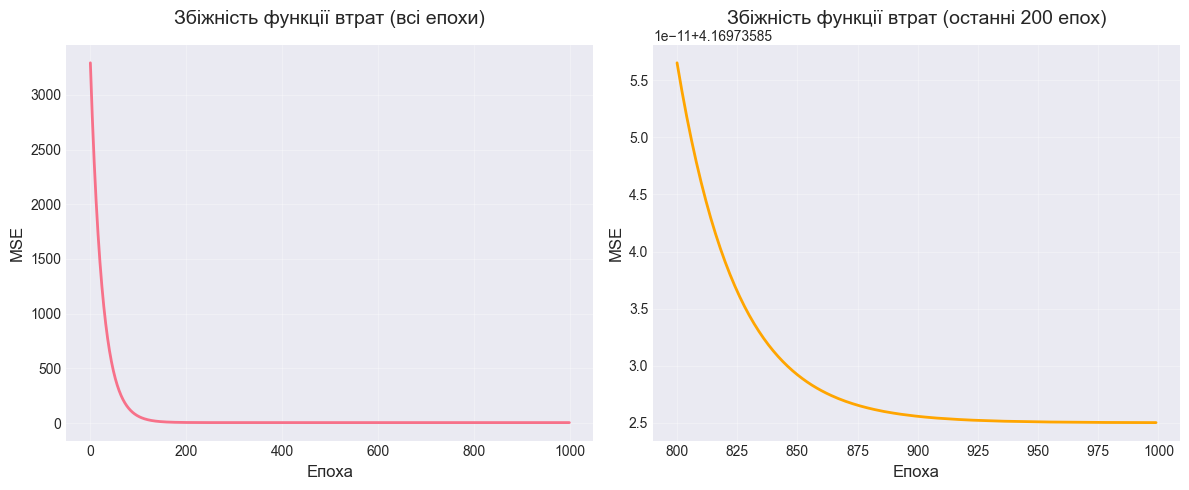

In [45]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(cost_history, linewidth=2)
plt.xlabel('Епоха', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.title('Збіжність функції втрат (всі епохи)', fontsize=14, pad=15)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Показуємо останні 200 епох для кращої візуалізації
plt.plot(range(len(cost_history) - 200, len(cost_history)),
         cost_history[-200:], linewidth=2, color='orange')
plt.xlabel('Епоха', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.title('Збіжність функції втрат (останні 200 епох)', fontsize=14, pad=15)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('cost_convergence.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. ОЦІНКА ЯКОСТІ МОДЕЛІ НА ТЕСТОВИХ ДАНИХ

### 3.1 Прогнозування та розрахунок метрик

In [46]:
# Прогнозування
y_pred_train = X_train_final.dot(b_final)
y_pred_test = X_test_final.dot(b_final)

# Розрахунок метрик
mse_train = np.mean((y_train - y_pred_train) ** 2)
mse_test = np.mean((y_test - y_pred_test) ** 2)

r2_train = 1 - (np.sum((y_train - y_pred_train) ** 2) /
                np.sum((y_train - np.mean(y_train)) ** 2))
r2_test = 1 - (np.sum((y_test - y_pred_test) ** 2) /
               np.sum((y_test - np.mean(y_test)) ** 2))

# RMSE для кращої інтерпретації
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

print(f"\n3.1 Метрики на навчальній вибірці:")
print(f"  - MSE:  {mse_train:.6f}")
print(f"  - RMSE: {rmse_train:.6f}")
print(f"  - R²:   {r2_train:.6f}")

print(f"\n3.2 Метрики на тестовій вибірці:")
print(f"  - MSE:  {mse_test:.6f}")
print(f"  - RMSE: {rmse_test:.6f}")
print(f"  - R²:   {r2_test:.6f}")


3.1 Метрики на навчальній вибірці:
  - MSE:  4.169736
  - RMSE: 2.041993
  - R²:   0.988690

3.2 Метрики на тестовій вибірці:
  - MSE:  4.082628
  - RMSE: 2.020552
  - R²:   0.988983


### 3.2 Порівняння з бейзлайном

In [47]:
baseline_pred = np.mean(y_train)
mse_baseline = np.mean((y_test - baseline_pred) ** 2)
r2_baseline = 1 - (np.sum((y_test - baseline_pred) ** 2) /
                   np.sum((y_test - np.mean(y_test)) ** 2))

print(f"\n3.3 Порівняння з бейзлайном (середнє значення):")
print(f"  - MSE бейзлайну:  {mse_baseline:.6f}")
print(f"  - R² бейзлайну:   {r2_baseline:.6f}")
print(f"  - Покращення MSE: {((mse_baseline - mse_test) / mse_baseline * 100):.2f}%")


3.3 Порівняння з бейзлайном (середнє значення):
  - MSE бейзлайну:  370.773038
  - R² бейзлайну:   -0.000507
  - Покращення MSE: 98.90%


### 3.3 Візуалізація прогнозів

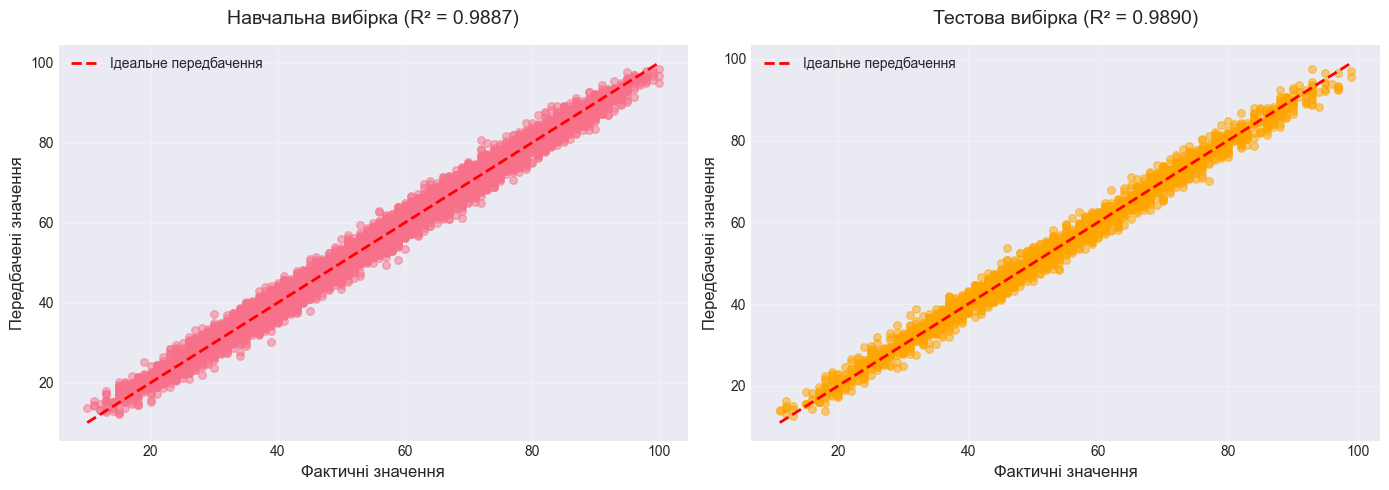

In [48]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_pred_train, alpha=0.5, s=30)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
         'r--', lw=2, label='Ідеальне передбачення')
plt.xlabel('Фактичні значення', fontsize=12)
plt.ylabel('Передбачені значення', fontsize=12)
plt.title(f'Навчальна вибірка (R² = {r2_train:.4f})', fontsize=14, pad=15)
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_test, alpha=0.5, s=30, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', lw=2, label='Ідеальне передбачення')
plt.xlabel('Фактичні значення', fontsize=12)
plt.ylabel('Передбачені значення', fontsize=12)
plt.title(f'Тестова вибірка (R² = {r2_test:.4f})', fontsize=14, pad=15)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('predictions_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. ПЕРЕВІРКА ПРИПУЩЕНЬ КЛАСИЧНОЇ ЛІНІЙНОЇ РЕГРЕСІЇ

### 4.1 Припущення 1: Лінійність зв'язку

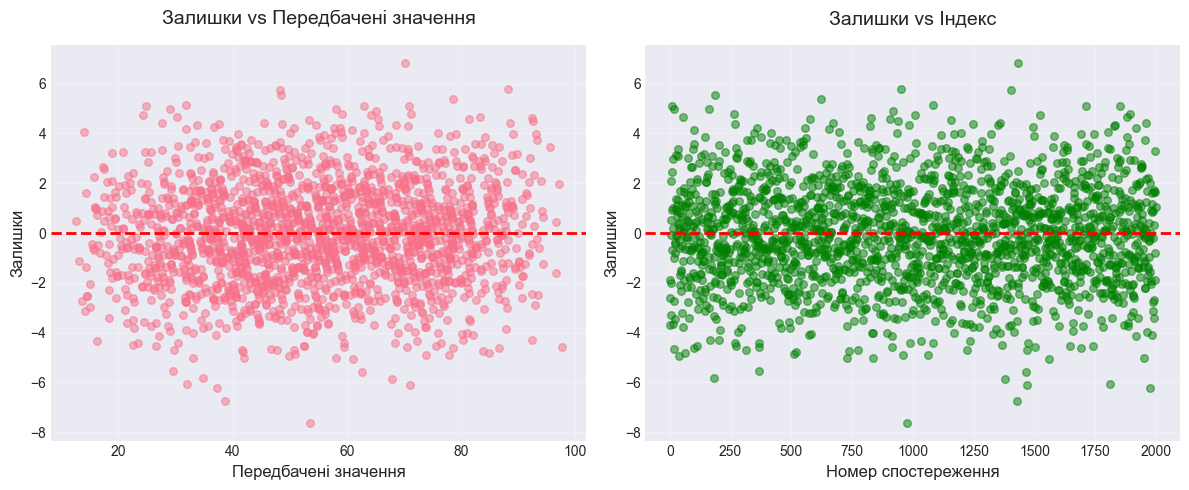

Стандартне відхилення залишків: 2.018976
Середнє значення залишків: -0.079784
✓ Залишки випадково розкидані навколо нуля
✓ ПРИПУЩЕННЯ ВИКОНУЄТЬСЯ: Лінійний зв'язок присутній


In [49]:
residuals = y_test - y_pred_test

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_pred_test, residuals, alpha=0.5, s=30)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Передбачені значення', fontsize=12)
plt.ylabel('Залишки', fontsize=12)
plt.title('Залишки vs Передбачені значення', fontsize=14, pad=15)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(range(len(residuals)), residuals, alpha=0.5, s=30, color='green')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Номер спостереження', fontsize=12)
plt.ylabel('Залишки', fontsize=12)
plt.title('Залишки vs Індекс', fontsize=14, pad=15)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('residuals_linearity.png', dpi=300, bbox_inches='tight')
plt.show()

# Аналіз паттернів
residual_std = np.std(residuals)
print(f"Стандартне відхилення залишків: {residual_std:.6f}")
print(f"Середнє значення залишків: {np.mean(residuals):.6f}")

if abs(np.mean(residuals)) < 0.1 * residual_std:
    print("✓ Залишки випадково розкидані навколо нуля")
    print("✓ ПРИПУЩЕННЯ ВИКОНУЄТЬСЯ: Лінійний зв'язок присутній")
else:
    print("✗ Можливо порушення лінійності")

### 4.2 Припущення 2: Відсутність мультиколінеарності (VIF)

In [50]:
# Обчислення VIF для кожної ознаки (без intercept)
vif_data = pd.DataFrame()
vif_data["Ознака"] = feature_cols
vif_data["VIF"] = [variance_inflation_factor(X_train_scaled, i)
                   for i in range(X_train_scaled.shape[1])]

print("\nТаблиця VIF (Variance Inflation Factor):")
print(vif_data.to_string(index=False))
print("\nІнтерпретація VIF:")
print("  - VIF < 5:  Відсутня мультиколінеарність")
print("  - 5 ≤ VIF < 10: Помірна мультиколінеарність")
print("  - VIF ≥ 10: Висока мультиколінеарність")

max_vif = vif_data["VIF"].max()
if max_vif < 5:
    print(f"\n✓ ПРИПУЩЕННЯ ВИКОНУЄТЬСЯ: Максимальний VIF = {max_vif:.2f} < 5")
elif max_vif < 10:
    print(f"\n⚠ ПРИПУЩЕННЯ ЧАСТКОВО ВИКОНУЄТЬСЯ: Максимальний VIF = {max_vif:.2f}")
else:
    print(f"\n✗ ПРИПУЩЕННЯ ПОРУШЕНЕ: Максимальний VIF = {max_vif:.2f} ≥ 10")


Таблиця VIF (Variance Inflation Factor):
                          Ознака      VIF
                   Hours Studied 1.000387
                 Previous Scores 1.000243
      Extracurricular Activities 1.000428
                     Sleep Hours 1.000461
Sample Question Papers Practiced 1.000320

Інтерпретація VIF:
  - VIF < 5:  Відсутня мультиколінеарність
  - 5 ≤ VIF < 10: Помірна мультиколінеарність
  - VIF ≥ 10: Висока мультиколінеарність

✓ ПРИПУЩЕННЯ ВИКОНУЄТЬСЯ: Максимальний VIF = 1.00 < 5


### 4.3 Припущення 3: Нормальність залишків

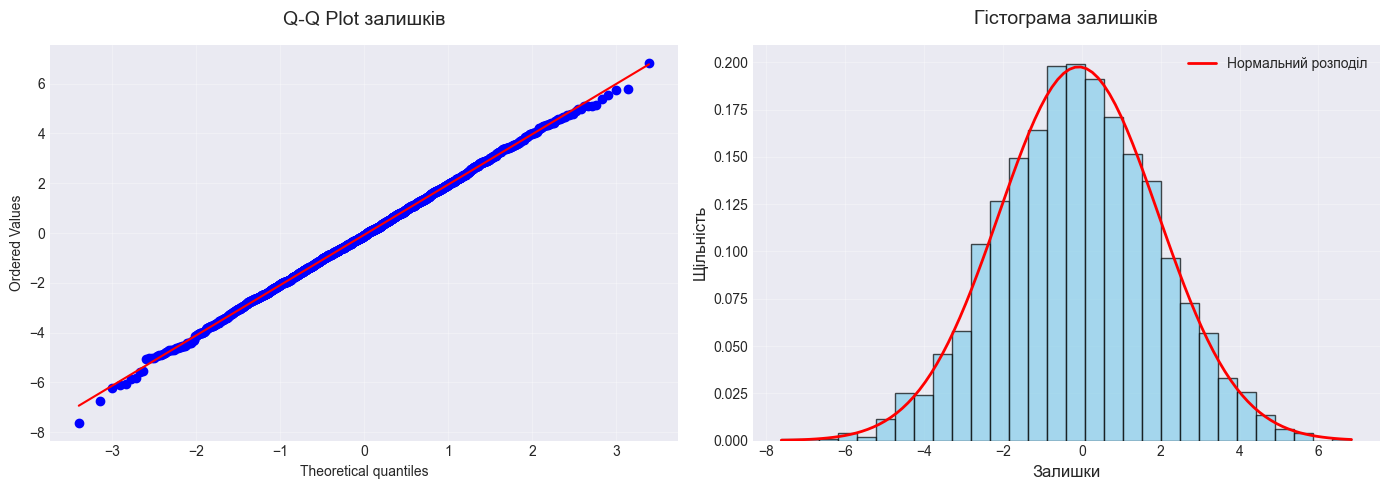


Тест Шапіро-Вілка:
  - Статистика: 0.999610
  - p-value:    0.975150
✓ ПРИПУЩЕННЯ ВИКОНУЄТЬСЯ: p-value > 0.05, залишки мають нормальний розподіл


In [51]:
plt.figure(figsize=(14, 5))

# Q-Q plot
plt.subplot(1, 2, 1)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot залишків', fontsize=14, pad=15)
plt.grid(True, alpha=0.3)

# Гістограма залишків
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')
# Накладаємо нормальний розподіл
mu, sigma = np.mean(residuals), np.std(residuals)
x = np.linspace(residuals.min(), residuals.max(), 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', lw=2, label='Нормальний розподіл')
plt.xlabel('Залишки', fontsize=12)
plt.ylabel('Щільність', fontsize=12)
plt.title('Гістограма залишків', fontsize=14, pad=15)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('residuals_normality.png', dpi=300, bbox_inches='tight')
plt.show()

# Статистичні тести
shapiro_stat, shapiro_p = stats.shapiro(residuals)
print(f"\nТест Шапіро-Вілка:")
print(f"  - Статистика: {shapiro_stat:.6f}")
print(f"  - p-value:    {shapiro_p:.6f}")

if shapiro_p > 0.05:
    print(f"✓ ПРИПУЩЕННЯ ВИКОНУЄТЬСЯ: p-value > 0.05, залишки мають нормальний розподіл")
else:
    print(f"✗ ПРИПУЩЕННЯ ПОРУШЕНЕ: p-value ≤ 0.05, залишки не мають нормального розподілу")
    print("  (Однак при великих вибірках ЦГТ забезпечує стійкість моделі)")

### 4.4 Припущення 4: Гомоскедастичність (постійна дисперсія)

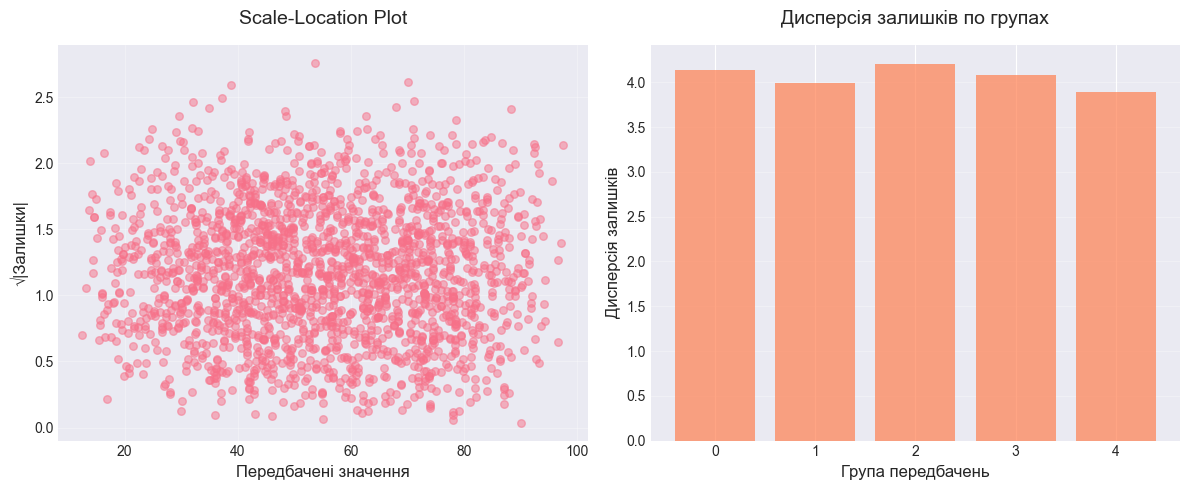


Відношення максимальної до мінімальної дисперсії: 1.08
✓ ПРИПУЩЕННЯ ВИКОНУЄТЬСЯ: Дисперсія залишків приблизно постійна


In [52]:
# Графік scale-location
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_pred_test, np.sqrt(np.abs(residuals)), alpha=0.5, s=30)
plt.xlabel('Передбачені значення', fontsize=12)
plt.ylabel('√|Залишки|', fontsize=12)
plt.title('Scale-Location Plot', fontsize=14, pad=15)
plt.grid(True, alpha=0.3)

# Розділимо передбачення на групи та порівняємо дисперсії
plt.subplot(1, 2, 2)
n_bins = 5
pred_bins = pd.qcut(y_pred_test, q=n_bins, duplicates='drop')
residual_var_by_bin = [residuals[pred_bins == bin_val].var()
                       for bin_val in pred_bins.unique()]
plt.bar(range(len(residual_var_by_bin)), residual_var_by_bin, alpha=0.7, color='coral')
plt.xlabel('Група передбачень', fontsize=12)
plt.ylabel('Дисперсія залишків', fontsize=12)
plt.title('Дисперсія залишків по групах', fontsize=14, pad=15)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('residuals_homoscedasticity.png', dpi=300, bbox_inches='tight')
plt.show()

# Аналіз
variance_ratio = max(residual_var_by_bin) / min(residual_var_by_bin)
print(f"\nВідношення максимальної до мінімальної дисперсії: {variance_ratio:.2f}")

if variance_ratio < 3:
    print(f"✓ ПРИПУЩЕННЯ ВИКОНУЄТЬСЯ: Дисперсія залишків приблизно постійна")
else:
    print(f"✗ ПРИПУЩЕННЯ ПОРУШЕНЕ: Значна гетероскедастичність (відношення > 3)")

### 4.5 Припущення 5: Відсутність автокореляції залишків


Тест Дарбіна-Вотсона:
  - Статистика DW: 2.047191
  - Інтерпретація:
    • DW ≈ 2.0: Відсутня автокореляція
    • DW < 1.5: Позитивна автокореляція
    • DW > 2.5: Негативна автокореляція
✓ ПРИПУЩЕННЯ ВИКОНУЄТЬСЯ: DW = 2.05 ≈ 2.0


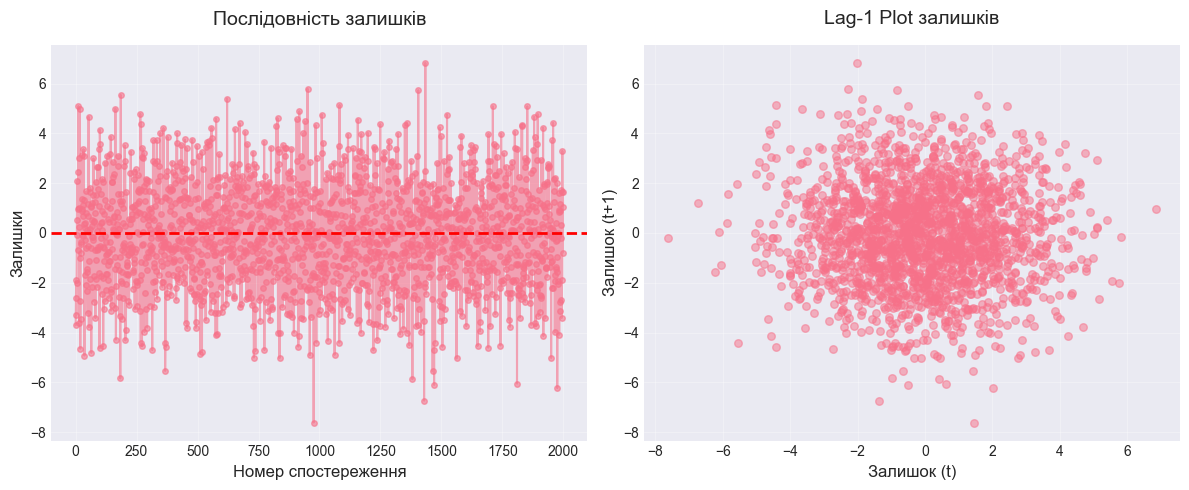

In [53]:
# Тест Дарбіна-Вотсона
dw_statistic = durbin_watson(residuals)
print(f"\nТест Дарбіна-Вотсона:")
print(f"  - Статистика DW: {dw_statistic:.6f}")
print(f"  - Інтерпретація:")
print(f"    • DW ≈ 2.0: Відсутня автокореляція")
print(f"    • DW < 1.5: Позитивна автокореляція")
print(f"    • DW > 2.5: Негативна автокореляція")

if 1.5 < dw_statistic < 2.5:
    print(f"✓ ПРИПУЩЕННЯ ВИКОНУЄТЬСЯ: DW = {dw_statistic:.2f} ≈ 2.0")
else:
    print(f"✗ ПРИПУЩЕННЯ ПОРУШЕНЕ: Можлива автокореляція залишків")

# Візуалізація автокореляції
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(residuals, marker='o', linestyle='-', alpha=0.6, markersize=4)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Номер спостереження', fontsize=12)
plt.ylabel('Залишки', fontsize=12)
plt.title('Послідовність залишків', fontsize=14, pad=15)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Автокореляційна функція (lag plot)
plt.scatter(residuals[:-1], residuals[1:], alpha=0.5, s=30)
plt.xlabel('Залишок (t)', fontsize=12)
plt.ylabel('Залишок (t+1)', fontsize=12)
plt.title('Lag-1 Plot залишків', fontsize=14, pad=15)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('residuals_autocorrelation.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.6 Припущення 6: Відсутність викидів та впливових спостережень

In [54]:
# Стандартизовані залишки
standardized_residuals = residuals / np.std(residuals)

# Викиди (|стандартизований залишок| > 3)
outliers = np.where(np.abs(standardized_residuals) > 3)[0]
print(f"\nВикиди (|стандартизований залишок| > 3):")
print(f"  - Кількість викидів: {len(outliers)} ({len(outliers) / len(residuals) * 100:.2f}%)")

if len(outliers) > 0:
    print(f"  - Індекси викидів: {outliers}")

# Cook's Distance (спрощений розрахунок)
leverage = np.diag(X_test_final @ np.linalg.pinv(X_train_final.T @ X_train_final) @ X_test_final.T)
cooks_d = (standardized_residuals ** 2 / X_test_final.shape[1]) * (leverage / (1 - leverage))

# Поріг Cook's distance
threshold = 4 / len(y_test)
influential = np.where(cooks_d > threshold)[0]

print(f"\nВпливові спостереження (Cook's Distance > {threshold:.4f}):")
print(f"  - Кількість впливових точок: {len(influential)} ({len(influential) / len(residuals) * 100:.2f}%)")


Викиди (|стандартизований залишок| > 3):
  - Кількість викидів: 5 (0.25%)
  - Індекси викидів: [ 976 1429 1434 1470 1975]

Впливові спостереження (Cook's Distance > 0.0020):
  - Кількість впливових точок: 0 (0.00%)


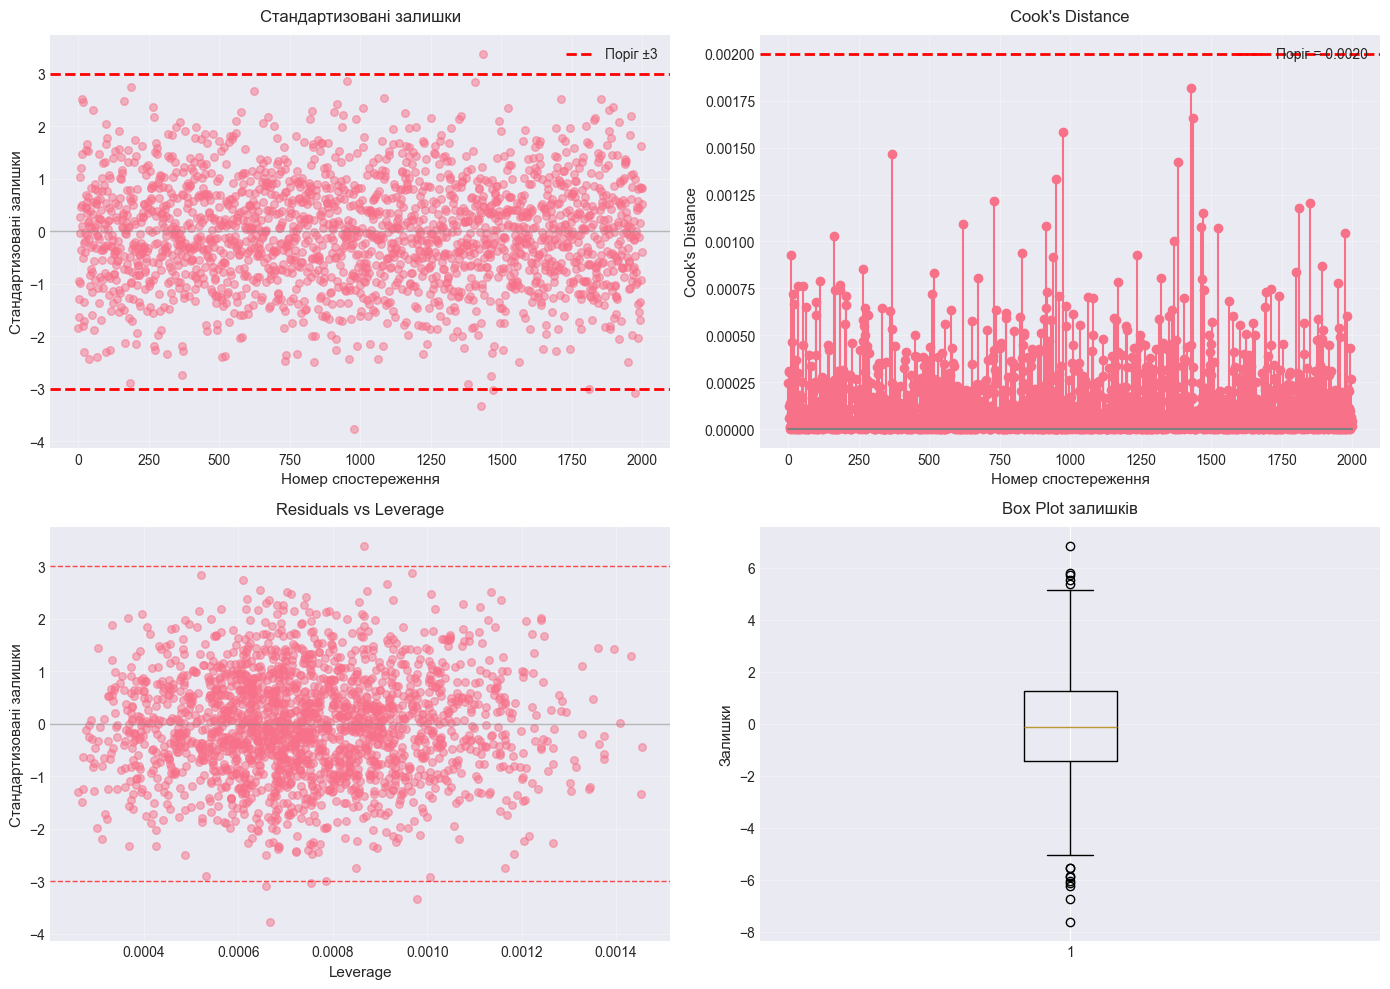


✓ ПРИПУЩЕННЯ ВИКОНУЄТЬСЯ: Незначна кількість викидів та впливових точок


In [55]:
# Візуалізація
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Стандартизовані залишки
axes[0, 0].scatter(range(len(standardized_residuals)), standardized_residuals, alpha=0.5, s=30)
axes[0, 0].axhline(y=3, color='r', linestyle='--', linewidth=2, label='Поріг ±3')
axes[0, 0].axhline(y=-3, color='r', linestyle='--', linewidth=2)
axes[0, 0].axhline(y=0, color='gray', linestyle='-', linewidth=1, alpha=0.5)
axes[0, 0].set_xlabel('Номер спостереження', fontsize=11)
axes[0, 0].set_ylabel('Стандартизовані залишки', fontsize=11)
axes[0, 0].set_title('Стандартизовані залишки', fontsize=12, pad=10)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Cook's Distance
axes[0, 1].stem(range(len(cooks_d)), cooks_d, linefmt='C0-', markerfmt='C0o', basefmt='gray')
axes[0, 1].axhline(y=threshold, color='r', linestyle='--', linewidth=2, label=f'Поріг = {threshold:.4f}')
axes[0, 1].set_xlabel('Номер спостереження', fontsize=11)
axes[0, 1].set_ylabel("Cook's Distance", fontsize=11)
axes[0, 1].set_title("Cook's Distance", fontsize=12, pad=10)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Residuals vs Leverage
axes[1, 0].scatter(leverage, standardized_residuals, alpha=0.5, s=30)
axes[1, 0].axhline(y=0, color='gray', linestyle='-', linewidth=1, alpha=0.5)
axes[1, 0].axhline(y=3, color='r', linestyle='--', linewidth=1, alpha=0.7)
axes[1, 0].axhline(y=-3, color='r', linestyle='--', linewidth=1, alpha=0.7)
axes[1, 0].set_xlabel('Leverage', fontsize=11)
axes[1, 0].set_ylabel('Стандартизовані залишки', fontsize=11)
axes[1, 0].set_title('Residuals vs Leverage', fontsize=12, pad=10)
axes[1, 0].grid(True, alpha=0.3)

# 4. Boxplot залишків
axes[1, 1].boxplot(residuals, vert=True)
axes[1, 1].set_ylabel('Залишки', fontsize=11)
axes[1, 1].set_title('Box Plot залишків', fontsize=12, pad=10)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('outliers_influential.png', dpi=300, bbox_inches='tight')
plt.show()

if len(outliers) < len(residuals) * 0.05 and len(influential) < len(residuals) * 0.05:
    print(f"\n✓ ПРИПУЩЕННЯ ВИКОНУЄТЬСЯ: Незначна кількість викидів та впливових точок")
else:
    print(f"\n⚠ ПРИПУЩЕННЯ ЧАСТКОВО ВИКОНУЄТЬСЯ: Присутні викиди/впливові спостереження")
    print(f"  Рекомендація: Розгляньте можливість видалення або трансформації даних")

## 5. ЗАГАЛЬНИЙ ВИСНОВОК

### 5.1 Підсумок перевірки припущень

In [56]:
print("\n5.1 ПІДСУМОК ПЕРЕВІРКИ ПРИПУЩЕНЬ:")
print("-" * 80)

assumptions_summary = {
    "1. Лінійність зв'язку": abs(np.mean(residuals)) < 0.1 * residual_std,
    "2. Відсутність мультиколінеарності": max_vif < 10,
    "3. Нормальність залишків": shapiro_p > 0.05,
    "4. Гомоскедастичність": variance_ratio < 3,
    "5. Відсутність автокореляції": 1.5 < dw_statistic < 2.5,
    "6. Відсутність викидів": len(outliers) < len(residuals) * 0.05
}

for assumption, is_met in assumptions_summary.items():
    status = "✓ ВИКОНУЄТЬСЯ" if is_met else "✗ ПОРУШЕНЕ"
    print(f"  {assumption}: {status}")


5.1 ПІДСУМОК ПЕРЕВІРКИ ПРИПУЩЕНЬ:
--------------------------------------------------------------------------------
  1. Лінійність зв'язку: ✓ ВИКОНУЄТЬСЯ
  2. Відсутність мультиколінеарності: ✓ ВИКОНУЄТЬСЯ
  3. Нормальність залишків: ✓ ВИКОНУЄТЬСЯ
  4. Гомоскедастичність: ✓ ВИКОНУЄТЬСЯ
  5. Відсутність автокореляції: ✓ ВИКОНУЄТЬСЯ
  6. Відсутність викидів: ✓ ВИКОНУЄТЬСЯ


### 5.2 Якість моделі

In [57]:
print("\n5.2 ЯКІСТЬ МОДЕЛІ:")
print("-" * 80)
print(f"  • R² на тестовій вибірці: {r2_test:.4f}")
print(f"    - Модель пояснює {r2_test * 100:.2f}% варіації цільової змінної")
print(f"  • RMSE на тестовій вибірці: {rmse_test:.4f}")
print(f"    - Середня помилка передбачення у тих же одиницях, що й Performance Index")
print(f"  • Покращення порівняно з бейзлайном: {((mse_baseline - mse_test) / mse_baseline * 100):.2f}%")


5.2 ЯКІСТЬ МОДЕЛІ:
--------------------------------------------------------------------------------
  • R² на тестовій вибірці: 0.9890
    - Модель пояснює 98.90% варіації цільової змінної
  • RMSE на тестовій вибірці: 2.0206
    - Середня помилка передбачення у тих же одиницях, що й Performance Index
  • Покращення порівняно з бейзлайном: 98.90%


### 5.3 Інтерпретація коефіцієнтів

In [58]:
print("\n5.3 ІНТЕРПРЕТАЦІЯ КОЕФІЦІЄНТІВ:")
print("-" * 80)
print(f"  • Intercept (β₀): {b_final[0]:.4f}")
print(f"    - Базове значення Performance Index при нульових (стандартизованих) предикторах")
print()

# Сортуємо коефіцієнти за абсолютним значенням
feature_importance = pd.DataFrame({
    'Ознака': feature_cols,
    'Коефіцієнт': b_final[1:],
    'Абсолютне значення': np.abs(b_final[1:])
})
feature_importance = feature_importance.sort_values('Абсолютне значення', ascending=False)

print("  • Вплив ознак (від найбільшого до найменшого):")
for idx, row in feature_importance.iterrows():
    direction = "позитивний" if row['Коефіцієнт'] > 0 else "негативний"
    print(f"    - {row['Ознака']}: {row['Коефіцієнт']:.4f} ({direction} вплив)")


5.3 ІНТЕРПРЕТАЦІЯ КОЕФІЦІЄНТІВ:
--------------------------------------------------------------------------------
  • Intercept (β₀): 55.3115
    - Базове значення Performance Index при нульових (стандартизованих) предикторах

  • Вплив ознак (від найбільшого до найменшого):
    - Previous Scores: 17.6373 (позитивний вплив)
    - Hours Studied: 7.4013 (позитивний вплив)
    - Sleep Hours: 0.8100 (позитивний вплив)
    - Sample Question Papers Practiced: 0.5488 (позитивний вплив)
    - Extracurricular Activities: -0.3043 (негативний вплив)


### 5.4 Візуалізація важливості ознак

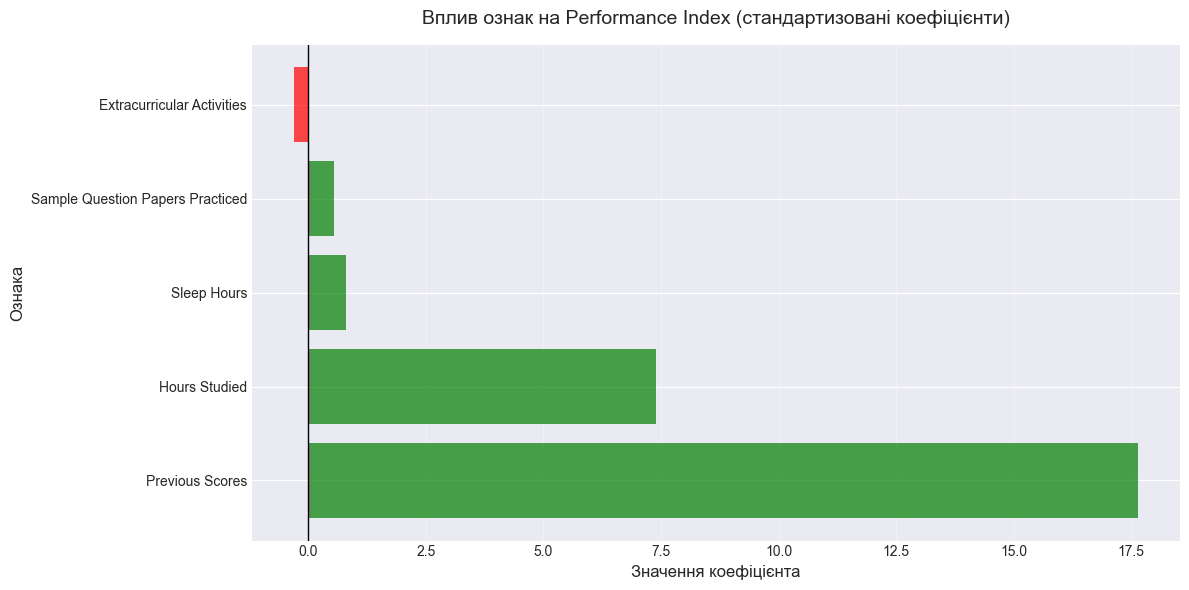

In [59]:
plt.figure(figsize=(12, 6))
colors = ['green' if x > 0 else 'red' for x in feature_importance['Коефіцієнт']]
plt.barh(range(len(feature_importance)), feature_importance['Коефіцієнт'], color=colors, alpha=0.7)
plt.yticks(range(len(feature_importance)), feature_importance['Ознака'])
plt.xlabel('Значення коефіцієнта', fontsize=12)
plt.ylabel('Ознака', fontsize=12)
plt.title('Вплив ознак на Performance Index (стандартизовані коефіцієнти)', fontsize=14, pad=15)
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

### 5.5 Придатність моделі та рекомендації

In [60]:
print("\n5.4 ПРИДАТНІСТЬ МОДЕЛІ:")
print("-" * 80)

# Підрахунок виконаних припущень
met_assumptions = sum(assumptions_summary.values())
total_assumptions = len(assumptions_summary)

if r2_test > 0.7 and met_assumptions >= 5:
    quality = "ВИСОКА"
    recommendation = "Модель придатна для прогнозування успішності студентів."
elif r2_test > 0.5 and met_assumptions >= 4:
    quality = "СЕРЕДНЯ"
    recommendation = "Модель може використовуватися з обережністю. Рекомендується покращення."
else:
    quality = "НИЗЬКА"
    recommendation = "Модель потребує значного покращення або перегляду підходу."

print(f"  • Загальна оцінка якості: {quality}")
print(f"  • Виконано припущень: {met_assumptions} з {total_assumptions}")
print(f"  • Рекомендація: {recommendation}")

print("\n5.5 МОЖЛИВІ ПОКРАЩЕННЯ:")
print("-" * 80)
print("  1. Feature Engineering:")
print("     - Додати поліноміальні ознаки для моделювання нелінійних залежностей")
print("     - Створити взаємодії між ознаками")
print("     - Розглянути трансформації (log, sqrt) для асиметричних розподілів")
print("  2. Регуляризація:")
print("     - Застосувати Ridge або Lasso регресію для зменшення перенавчання")
print("  3. Обробка викидів:")
print("     - Видалити або трансформувати виявлені викиди")
print("  4. Альтернативні моделі:")
print("     - Розглянути нелінійні моделі (дерева рішень, випадковий ліс, градієнтний бустинг)")

print("\n" + "=" * 80)
print("АНАЛІЗ ЗАВЕРШЕНО")
print("=" * 80)
print(f"\nЗбережені графіки:")
print("  - correlation_heatmap.png")
print("  - cost_convergence.png")
print("  - predictions_comparison.png")
print("  - residuals_linearity.png")
print("  - residuals_normality.png")
print("  - residuals_homoscedasticity.png")
print("  - residuals_autocorrelation.png")
print("  - outliers_influential.png")
print("  - feature_importance.png")
print("\nДякуємо за увагу!")


5.4 ПРИДАТНІСТЬ МОДЕЛІ:
--------------------------------------------------------------------------------
  • Загальна оцінка якості: ВИСОКА
  • Виконано припущень: 6 з 6
  • Рекомендація: Модель придатна для прогнозування успішності студентів.

5.5 МОЖЛИВІ ПОКРАЩЕННЯ:
--------------------------------------------------------------------------------
  1. Feature Engineering:
     - Додати поліноміальні ознаки для моделювання нелінійних залежностей
     - Створити взаємодії між ознаками
     - Розглянути трансформації (log, sqrt) для асиметричних розподілів
  2. Регуляризація:
     - Застосувати Ridge або Lasso регресію для зменшення перенавчання
  3. Обробка викидів:
     - Видалити або трансформувати виявлені викиди
  4. Альтернативні моделі:
     - Розглянути нелінійні моделі (дерева рішень, випадковий ліс, градієнтний бустинг)

АНАЛІЗ ЗАВЕРШЕНО

Збережені графіки:
  - correlation_heatmap.png
  - cost_convergence.png
  - predictions_comparison.png
  - residuals_linearity.png
  - resid